## ResNet18 - MNIST

In [27]:
import sys
#sys.path.append('../models')
#sys.path.append('.../EvaluateFeatureExtractor')
from resnet import *



In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from resnet import ResNet18
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [106]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [147]:

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create the data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


nclass = 10 # number of classes
scale = 64 # scale factor for num channels
channels = 1 # number of input channels

model = ResNet18(nclass, scale, channels, proto_layer=4,layer_norm = False, entry_stride = 1).to(device)

# Define the loss function
cost = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10


64


In [174]:
def cos_sim(model, train_loader, dataset_name, num_epochs):
    
    model.eval()
    model.load_state_dict(torch.load(f'model_{dataset_name}_epoch_{num_epochs+1}.pth'))
    model.to(device)

    intra_sim,inter_sim = [],[]


    with torch.no_grad():
        
        for inputs, labels in train_loader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            feat_vec = model(inputs)  ## get feature vectors from the model

            # norm_feat_vec = F.normalize(feat_vec)
            # CosSimMatrix = torch.mm(norm_feat_vec, norm_feat_vec.t()) ## calculate cosine similarity matrix


            for i in range(len(feat_vec)):
                for j in range(i+1, len(feat_vec)):
           
                    sim = F.cosine_similarity(feat_vec[i].unsqueeze(0), feat_vec[j].unsqueeze(0)) ## calculate cosine similarity between feature vectors
                    #sim = CosSimMatrix[i][j]
                   
                    if labels[i] == labels[j]:      #within class
                        intra_sim.append(sim.item())
                    else:                           #between class
                        inter_sim.append(sim.item())
                  
    return intra_sim, inter_sim #, CosSimMatrix

Note torch.nn.functional.cosine_similarity is defined as:
 $$
\text{CosSim} = \frac{\vec{x}_1 \cdot \vec{x}_2}{\max(\|\vec{x}_1\|_2, \epsilon) \cdot \max(\|\vec{x}_2\|_2, \epsilon)}
 $$
 where $\epsilon$ is 1e-8 to avoid division by 0 and the magnitude is defined as $L_2$ norm

In [177]:
def train(model, train_loader, optimizer, dataset_name, num_epochs):
    
    total_step = len(train_loader)
   
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward pass ##
            outputs = model(images)
            loss = cost(outputs, labels)

            ## backwards pass and optimizer step (learning) ##
            optimizer.zero_grad()  # zeroes out the gradients, removing exisitng ones to avoid accumulation
            loss.backward()  # gradient of loss, how much each parameter contributed to the loss
            optimizer.step()  # adjusts parameters based on results to minimize loss

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
    torch.save(model.state_dict(), f'model_{dataset_name}_epoch_{num_epochs+1}.pth') #save after training        

 Train model

In [153]:
train(model, train_loader, optimizer, 'mnist', num_epochs)

Epoch [1/10], Step [100/938], Loss: 0.2097
Epoch [1/10], Step [200/938], Loss: 0.0604
Epoch [1/10], Step [300/938], Loss: 0.0889
Epoch [1/10], Step [400/938], Loss: 0.0688
Epoch [1/10], Step [500/938], Loss: 0.1139
Epoch [1/10], Step [600/938], Loss: 0.0429
Epoch [1/10], Step [700/938], Loss: 0.0258
Epoch [1/10], Step [800/938], Loss: 0.0249
Epoch [1/10], Step [900/938], Loss: 0.0642
Epoch [2/10], Step [100/938], Loss: 0.0141
Epoch [2/10], Step [200/938], Loss: 0.0266
Epoch [2/10], Step [300/938], Loss: 0.0400
Epoch [2/10], Step [400/938], Loss: 0.0253
Epoch [2/10], Step [500/938], Loss: 0.0337
Epoch [2/10], Step [600/938], Loss: 0.0463
Epoch [2/10], Step [700/938], Loss: 0.0096
Epoch [2/10], Step [800/938], Loss: 0.0298
Epoch [2/10], Step [900/938], Loss: 0.0058
Epoch [3/10], Step [100/938], Loss: 0.0094
Epoch [3/10], Step [200/938], Loss: 0.0166
Epoch [3/10], Step [300/938], Loss: 0.0033
Epoch [3/10], Step [400/938], Loss: 0.0059
Epoch [3/10], Step [500/938], Loss: 0.0010
Epoch [3/10

Compute cos_sim()

In [175]:
intra_sim, inter_sim = cos_sim(model, train_loader, 'mnist', num_epochs)
intra_sim_np, inter_sim_np = np.array(intra_sim), np.array(inter_sim)


Display Results

In [176]:
def print_res(intra_sim_np, inter_sim_np):
    print(f"Intra-class Similarity: {intra_sim_np}\nInter-class Similarity: {inter_sim_np}]\n")
    print(f"Inter-class Similarity: Mean = {inter_sim_np.mean()}, Std = {inter_sim_np.std()}, Var = {np.var(inter_sim)}\nIntra-class similarity: Mean = {intra_sim_np.mean()}, Std = {intra_sim_np.std()}, Var = {np.var(intra_sim)}")

print_res(intra_sim_np, inter_sim_np)

Intra-class Similarity: [0.98530084 0.96215093 0.92196929 ... 0.95257872 0.97671348 0.95976418]
Inter-class Similarity: [-0.1507372  -0.14609425 -0.17019704 ... -0.35056907  0.24749766
  0.02510547]]

Inter-class Similarity: Mean = -0.10063373813152347, Std = 0.20337095732321842, Var = 0.041359746282562324
Intra-class similarity: Mean = 0.9411961720013292, Std = 0.04879488217100625, Var = 0.0023809405260823836


 Plot results

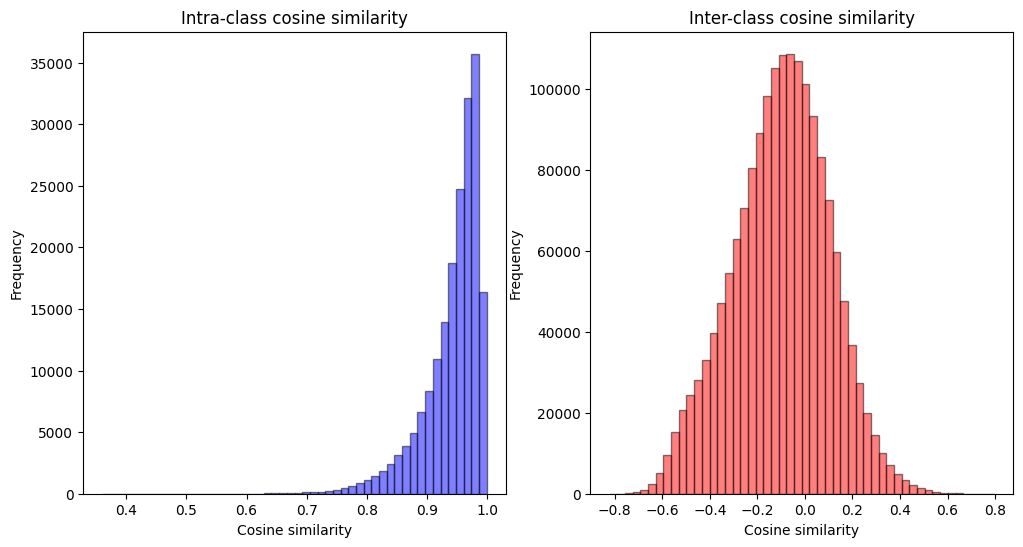

In [166]:
def plot_hist(intra_sim_np, inter_sim_np):
    plt.figure(figsize=(12,6))

    #Intra-class similarity
    plt.subplot(1,2,1)
    plt.hist(intra_sim_np, bins=50, color='blue', edgecolor='black', alpha=0.5)
    plt.title("Intra-class cosine similarity")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")

    #Inter-class similarity
    plt.subplot(1,2,2)
    plt.hist(inter_sim_np, bins=50, color='red', edgecolor='black', alpha=0.5)
    plt.title("Inter-class cosine similarity")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")

    plt.show()



    
plot_hist(intra_sim_np, inter_sim_np)

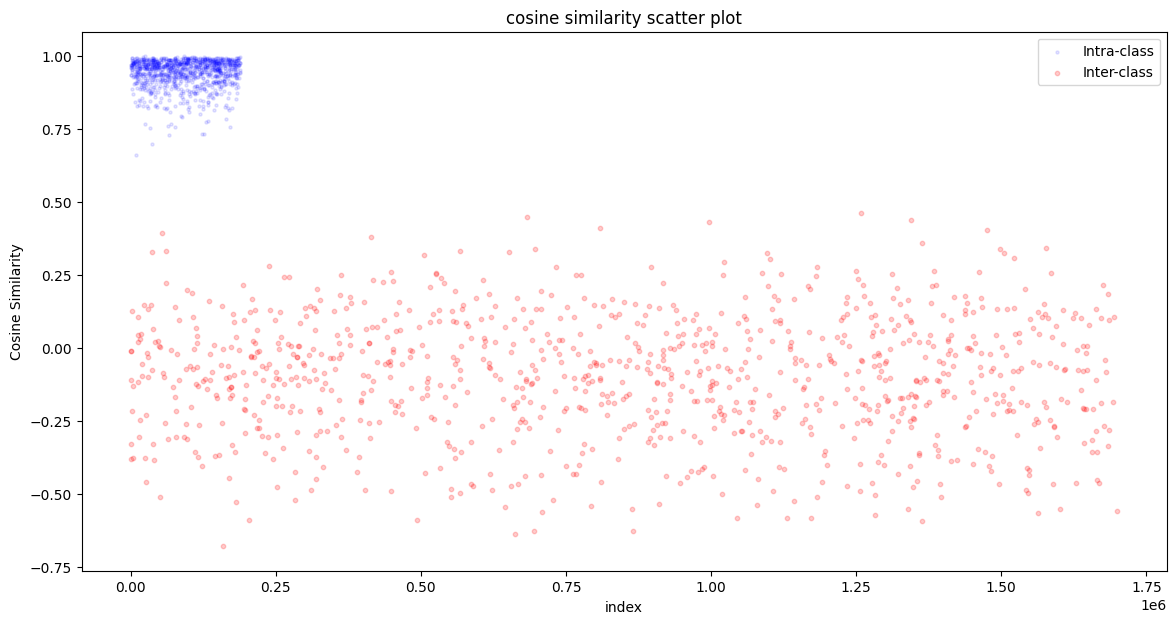

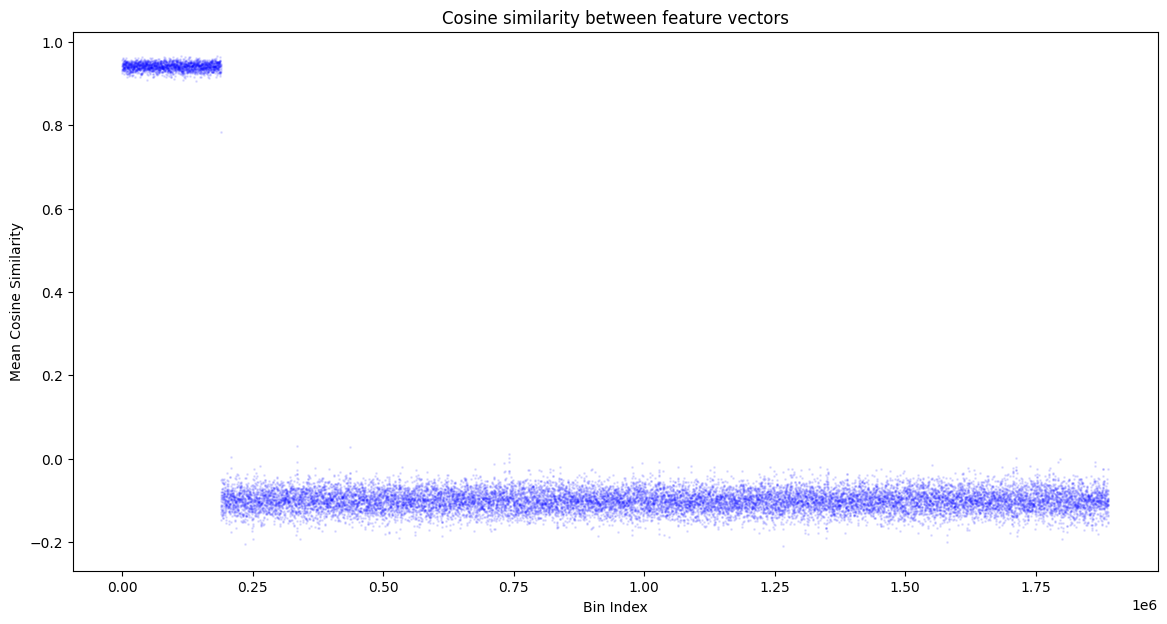

In [219]:
def plot_scatter(intra_sim,inter_sim,sample_size=1000):


    plt.figure(figsize=(14,7))

    intra_indices = np.random.choice(range(len(intra_sim)), sample_size, replace=False)
    inter_indices = np.random.choice(range(len(inter_sim)), sample_size, replace=False) 

    intra_class_sample = np.array(intra_sim)[intra_indices]
    inter_class_sample = np.array(inter_sim)[inter_indices]
    

    plt.scatter(intra_indices, intra_class_sample, color='blue', alpha=0.1, label='Intra-class',s=5)
    plt.scatter(inter_indices, inter_class_sample, color='red', alpha=0.2, label='Inter-class',s=10)

    plt.title("cosine similarity scatter plot")
    plt.xlabel("index")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.show()

def agg_scatter(intra_sim_np, inter_sim_np, bin_size=100):
    cos_sim = np.concatenate((intra_sim_np, inter_sim_np))
    
    binned_means = [np.mean(cos_sim[i:i+bin_size]) for i in range(0, len(cos_sim), bin_size)]

    plt.figure(figsize=(14,7))

    plt.scatter(range(0,len(cos_sim),bin_size), binned_means, color='blue', alpha=0.1, s=1)
    plt.title("Cosine similarity between feature vectors")
    plt.xlabel("Bin Index")
    plt.ylabel("Mean Cosine Similarity")
    plt.show()    

plot_scatter(intra_sim_np,inter_sim_np)
agg_scatter(intra_sim_np, inter_sim_np)

## ResNet -- Cifar10
define new model parameters

In [184]:

# Define the data transformations
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training dataset
cifar_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create the data loader
cifar_train_loader = torch.utils.data.DataLoader(cifar_train_dataset, batch_size=64, shuffle=True)

# Define the number of classes
cifar_nclass = 10
cifar_scale = 32
cifar_channels = 3

# Create an instance of ResNet18 model
cifar_model = ResNet18(cifar_nclass, cifar_scale, cifar_channels, proto_layer=4,layer_norm = False, entry_stride = 1).to(device)

#Define optimizer
cifar_optimizer = optim.SGD(cifar_model.parameters(), lr=0.01)

cifar_num_epochs = 50


Files already downloaded and verified
32


In [185]:
train(cifar_model, cifar_train_loader, cifar_optimizer, 'cifar10', cifar_num_epochs)

Epoch [1/50], Step [100/782], Loss: 2.0536
Epoch [1/50], Step [200/782], Loss: 1.7263
Epoch [1/50], Step [300/782], Loss: 1.6542
Epoch [1/50], Step [400/782], Loss: 1.4548
Epoch [1/50], Step [500/782], Loss: 1.4042
Epoch [1/50], Step [600/782], Loss: 1.3442
Epoch [1/50], Step [700/782], Loss: 1.3455
Epoch [2/50], Step [100/782], Loss: 1.2393
Epoch [2/50], Step [200/782], Loss: 1.3195
Epoch [2/50], Step [300/782], Loss: 1.2401
Epoch [2/50], Step [400/782], Loss: 1.1450
Epoch [2/50], Step [500/782], Loss: 1.1668
Epoch [2/50], Step [600/782], Loss: 1.2990
Epoch [2/50], Step [700/782], Loss: 1.0239
Epoch [3/50], Step [100/782], Loss: 1.1003
Epoch [3/50], Step [200/782], Loss: 1.1335
Epoch [3/50], Step [300/782], Loss: 1.2141
Epoch [3/50], Step [400/782], Loss: 0.8028
Epoch [3/50], Step [500/782], Loss: 0.9608
Epoch [3/50], Step [600/782], Loss: 0.6902
Epoch [3/50], Step [700/782], Loss: 0.9759
Epoch [4/50], Step [100/782], Loss: 0.8949
Epoch [4/50], Step [200/782], Loss: 0.8955
Epoch [4/50

In [189]:
cifar_intra_sim, cifar_inter_sim = cos_sim(cifar_model, cifar_train_loader, 'cifar10',cifar_num_epochs)
cifar_intra_sim_np, cifar_inter_sim_np = np.array(cifar_intra_sim), np.array(cifar_inter_sim)


In [190]:
print_res(cifar_intra_sim_np, cifar_inter_sim_np)

Intra-class Similarity: [0.70867956 0.88956451 0.5763582  ... 0.40294367 0.90070522 0.73217213]
Inter-class Similarity: [-0.25093558 -0.36975142 -0.27410099 ...  0.55406034 -0.08303329
  0.09156772]]

Inter-class Similarity: Mean = -0.024227226811092264, Std = 0.3826644819483011, Var = 0.041359746282562324
Intra-class similarity: Mean = 0.7595558089955304, Std = 0.16191577894777248, Var = 0.0023809405260823836


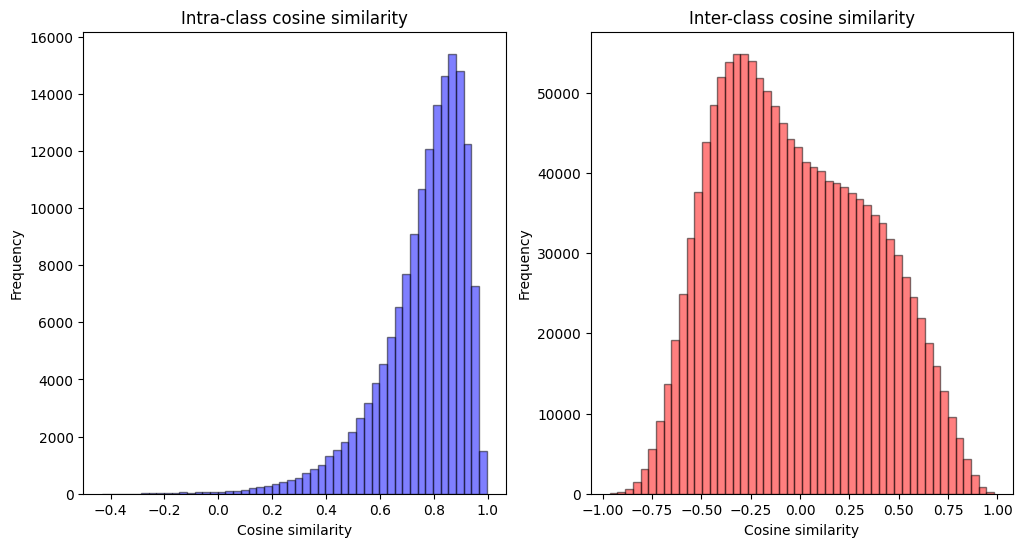

In [191]:
plot_hist(cifar_intra_sim_np, cifar_inter_sim_np)

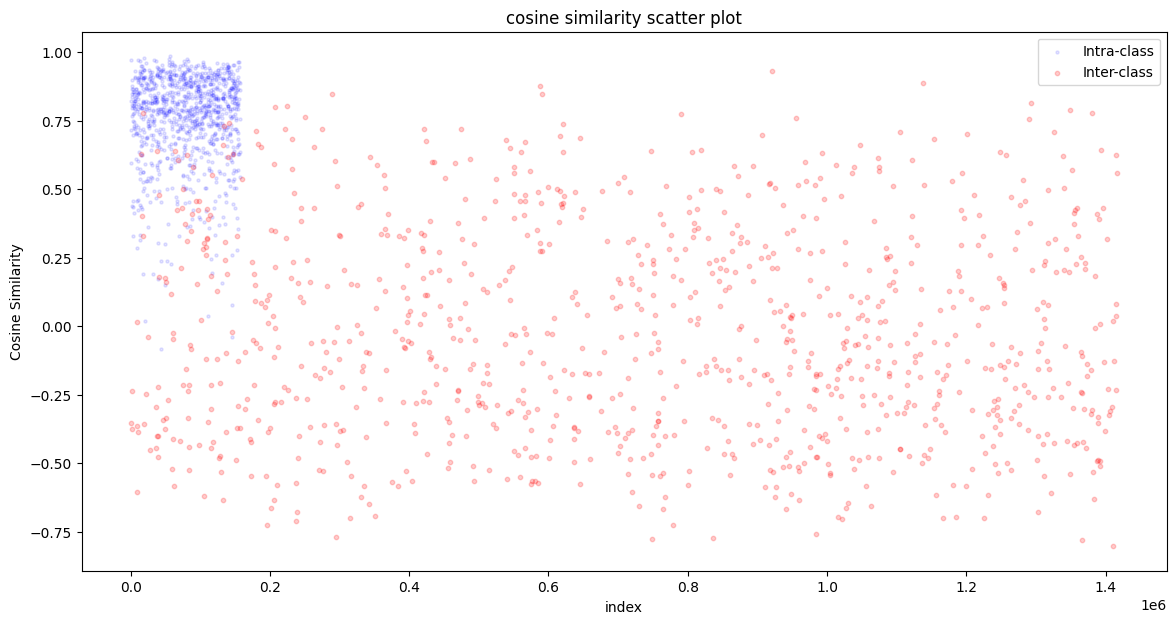

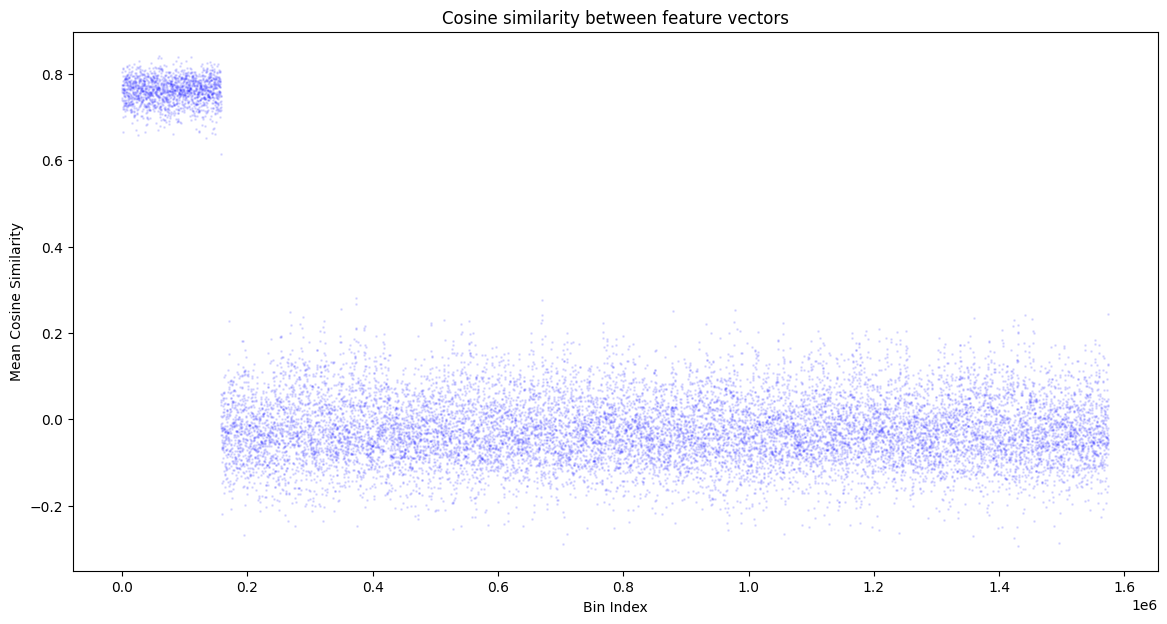

In [220]:
plot_scatter(cifar_intra_sim_np, cifar_inter_sim_np)
agg_scatter(cifar_intra_sim_np, cifar_inter_sim_np)